In [1]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
import os
import numpy as np
import duckdb
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from collections import defaultdict
from tqdm import tqdm
import copy
import json
#from difflib import SequenceMatcher
#from collections import Counter
#from itertools import chain

In [2]:
import re

def extrair_numero(texto):
  return re.findall(r'\d+', texto)[0].lstrip('0')

In [3]:
jurisprudencias = pd.read_csv("jurisprudencias0-2000.csv")
jurisprudencias['ref'] = jurisprudencias['ref'].astype(str)
jurisprudencias

,seqDocumento,ref
0,144948780,A 200910000001130
1,144948780,CU no 308898
2,144948780,Esp 328391
3,144948780,Esp 403153
4,144948780,J 146/6
...,...,...
27171,145730312,do sumular n. 182 desta Corte Superior.
27172,145730312,do sumular n. 182 do STJ
27173,145730312,g nos EDcl no AREsp n. 1.785.474/SC
27174,145730312,mula n. 182 do STJ


In [4]:
jurisprudencias = jurisprudencias[jurisprudencias['ref'].str.contains('\d')]
jurisprudencias['ref_numers'] = jurisprudencias['ref'].apply(lambda x: extrair_numero(x))
jurisprudencias

/tmp/ipykernel_59351/2164627914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jurisprudencias['ref_numers'] = jurisprudencias['ref'].apply(lambda x: extrair_numero(x))


,seqDocumento,ref,ref_numers
0,144948780,A 200910000001130,200910000001130
1,144948780,CU no 308898,308898
2,144948780,Esp 328391,328391
3,144948780,Esp 403153,403153
4,144948780,J 146/6,146
...,...,...,...
27171,145730312,do sumular n. 182 desta Corte Superior.,182
27172,145730312,do sumular n. 182 do STJ,182
27173,145730312,g nos EDcl no AREsp n. 1.785.474/SC,1
27174,145730312,mula n. 182 do STJ,182


In [5]:
contagem = jurisprudencias['ref_numers'].value_counts()
contagem

ref_numers
1          2818
7          2380
182        2191
691         940
83          757
           ... 
676834        1
224655        1
5377          1
1707850       1
1106797       1
Name: count, Length: 2831, dtype: int64

In [6]:
jurisprudencias = jurisprudencias.join(contagem, on='ref_numers', rsuffix='_contagem')
jurisprudencias = jurisprudencias.sort_values(by='count', ascending=False)
jurisprudencias

,seqDocumento,ref,ref_numers,count
15091,145522785,t no AREsp 1.621.900/MG,1,2818
24674,145501377,t no AREsp. 1.504.312/AL,1,2818
16032,145496750,Esp n. 1.740.911/DF,1,2818
16030,145496750,1-02.2017.8.26.0576,1,2818
24677,145501377,t no REsp 1.816.648/AL,1,2818
...,...,...,...,...
12934,145717236,HC no 0627902-36.2020.8.06.0000,627902,1
12923,146031577,t no AREsp 1816495/RS,1816495,1
12899,146038784,t no REsp 1758267/RN,1758267,1
12898,146038784,t no AgRg no REsp 1580246/RS,1580246,1


In [7]:
import matplotlib.pyplot as plt

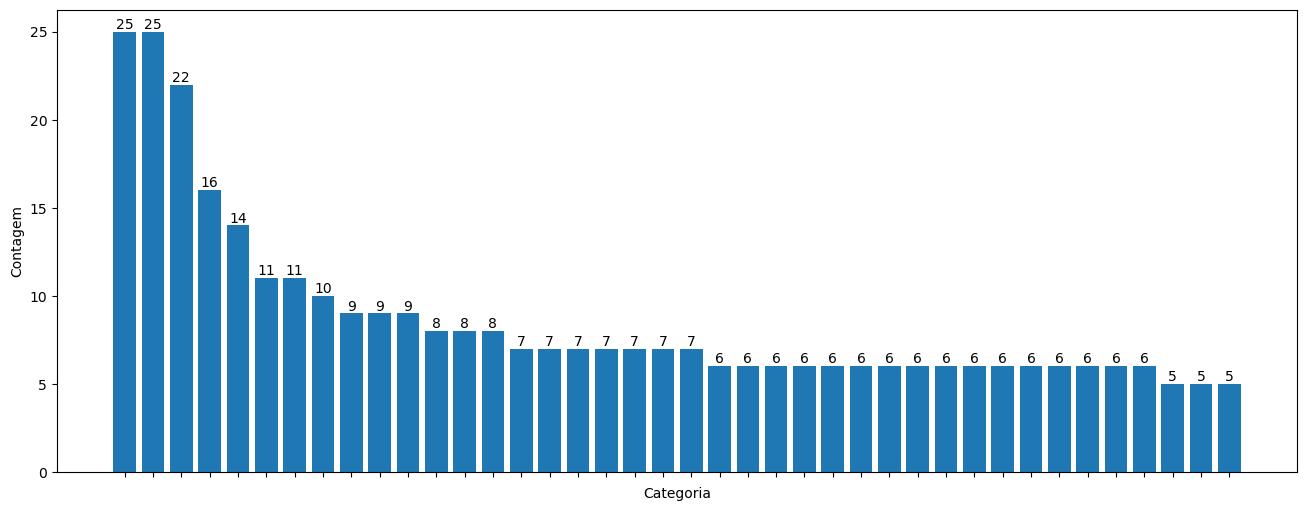

In [8]:
df_filtered = jurisprudencias[jurisprudencias['ref_numers'].str.len() > 3]
df_filtered = df_filtered.query('count > 3')
top_n = 40
value_counts = df_filtered['ref_numers'].value_counts()
top_categories = value_counts[:top_n]

# Criando um gráfico de barras a partir do resultado
plt.figure(figsize=(16, 6))
plt.bar(top_categories.index, top_categories.values)
# Remover as etiquetas do eixo y
plt.gca().set_xticklabels([])

for i in range(len(top_categories.index)):
    plt.text(top_categories.index[i], top_categories.values[i], str(top_categories.values[i]), ha='center', va='bottom')

plt.xlabel('Categoria')
plt.ylabel('Contagem')
plt.show()

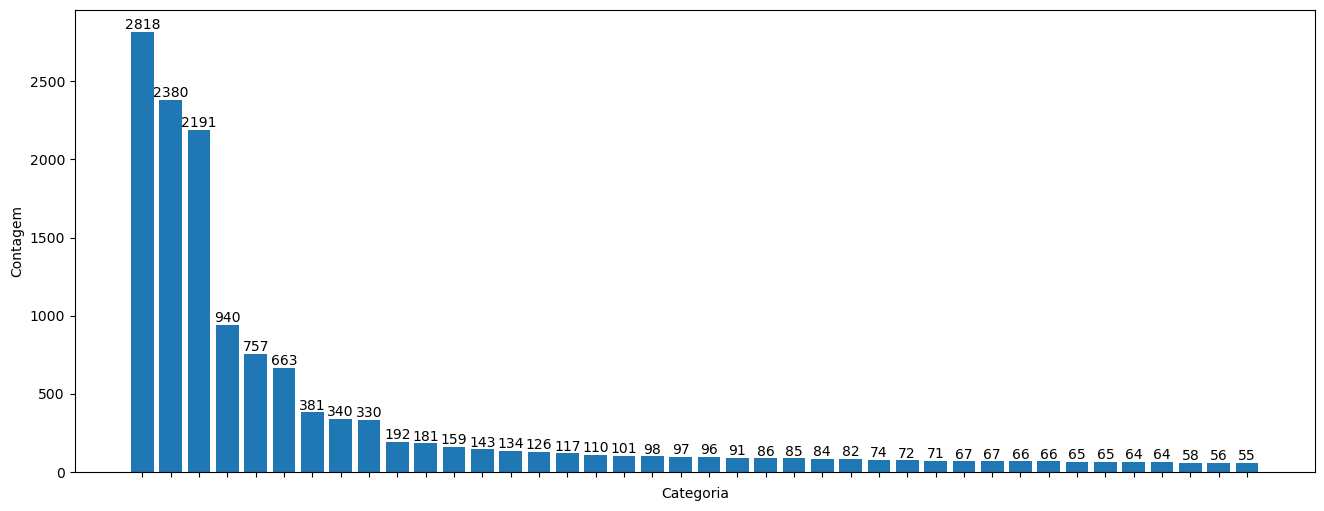

In [9]:
top_n = 40
value_counts = jurisprudencias['ref_numers'].value_counts()
top_categories = value_counts[:top_n]

# Criando um gráfico de barras a partir do resultado
plt.figure(figsize=(16, 6))
plt.bar(top_categories.index, top_categories.values)
# Remover as etiquetas do eixo y
plt.gca().set_xticklabels([])

for i in range(len(top_categories.index)):
    plt.text(top_categories.index[i], top_categories.values[i], str(top_categories.values[i]), ha='center', va='bottom')
    
plt.xlabel('Categoria')
plt.ylabel('Contagem')
plt.show()

In [10]:
graph = jurisprudencias[['seqDocumento','ref_numers']].rename(columns={'seqDocumento': 'Source'})
graph = graph.rename(columns={'ref_numers': 'Target'})
graph.to_csv('graph_jurisprudencias0-2000.csv', index=False)
graph

,Source,Target
15091,145522785,1
24674,145501377,1
16032,145496750,1
16030,145496750,1
24677,145501377,1
...,...,...
12934,145717236,627902
12923,146031577,1816495
12899,146038784,1758267
12898,146038784,1580246
